In [1]:
#Note accounting CRSP info seems to be in millions

import pandas as pd
import numpy as np
import os


import pandas_datareader as pdr  # to install: !pip install pandas_datareader
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt 
from scipy import stats
from sklearn.linear_model import LinearRegression

from statsmodels.formula.api import ols as sm_ols
from statsmodels.iolib.summary2 import summary_col # nicer tables
import statsmodels.api as sm

# importing required modules
from zipfile import ZipFile
import zipfile
import time

In [2]:
#Compustat data - roughly 1min to load 
fundamentals = pd.concat((chunk for chunk in pd.read_csv('fundamentals.csv',chunksize=100000, low_memory=False)))
fundamentals.shape #~500k rows, 659 columns 

(501147, 659)

In [3]:
fundamentals['cusip'] = fundamentals['cusip'].astype(str).str[:-1]

In [4]:
fundamentals['cusip']

0         00036110
1         00036110
2         00036110
3         00036110
4         00036110
            ...   
501142    21077C10
501143    21077C10
501144    21077C10
501145    21077C10
501146    21077C10
Name: cusip, Length: 501147, dtype: object

In [5]:
#CRSP data - roughly 10 seconds to load 
returns = pd.concat((chunk for chunk in pd.read_csv('returns.csv',chunksize=100000, low_memory=False)))
returns.shape #~5.7 million rows, 16 columns

(5711711, 16)

In [6]:
#cleaning up returns dataset - roughly 10 sec to load

returns['date'] = pd.to_datetime(returns['date'], format='%Y%m%d', errors='coerce') #change dates format 
returns.sort_values(by='date') # This now sorts in date order
returns #returns in number format, not percentages 
returns[['prc','vol','ret','shrout','sprtrn']] = returns[['prc','vol','ret','shrout','sprtrn']].apply(pd.to_numeric, errors='coerce') #had to change the num to to numeric values 
#returns['ticker'].nunique() #have stock return data on 9,670 firms 
returns.head()

,Unnamed: 0,permno,date,siccd,ncusip,ticker,comnam,shrcls,naics,prc,vol,ret,shrout,cfacpr,cfacshr,sprtrn
0,0,10026,2018-01-02,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,149.17999,190618.0,-0.017454,18668.0,1.0,1.0,0.008303
1,1,10026,2018-01-03,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,147.69000,63693.0,-0.009988,18668.0,1.0,1.0,0.006399
2,2,10026,2018-01-04,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,149.73000,127552.0,0.013813,18668.0,1.0,1.0,0.004029
3,3,10026,2018-01-05,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,148.30000,44647.0,-0.009550,18668.0,1.0,1.0,0.007034
4,4,10026,2018-01-08,2052,46603210,JJSF,J & J SNACK FOODS CORP,NaN,311821.0,148.41000,55014.0,0.000742,18668.0,1.0,1.0,0.001662


In [7]:
fundamentals.sort_values(by='fyearq').reset_index() # This now sorts in date order
fundamentals.head()

,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,prirow,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,ipodate
0,0,1004,2010-02-28,2009.0,3.0,5.0,INDL,C,D,STD,...,NaN,1.0,5080.0,110.0,925.0,B,IL,0.0,www.aarcorp.com,1988-01-01
1,1,1004,2010-05-31,2009.0,4.0,5.0,INDL,C,D,STD,...,NaN,1.0,5080.0,110.0,925.0,B,IL,0.0,www.aarcorp.com,1988-01-01
2,2,1004,2010-08-31,2010.0,1.0,5.0,INDL,C,D,STD,...,NaN,1.0,5080.0,110.0,925.0,B,IL,0.0,www.aarcorp.com,1988-01-01
3,3,1004,2010-11-30,2010.0,2.0,5.0,INDL,C,D,STD,...,NaN,1.0,5080.0,110.0,925.0,B,IL,0.0,www.aarcorp.com,1988-01-01
4,4,1004,2011-02-28,2010.0,3.0,5.0,INDL,C,D,STD,...,NaN,1.0,5080.0,110.0,925.0,B,IL,0.0,www.aarcorp.com,1988-01-01


In [8]:
#group returns by quarter
#group return dates by 3/31, 6/30, 9/30, 12/31 


returns['Gross_Ret'] = 1 + returns['ret']

q2_2018 = ((returns[(returns['date'] >= '2018-03-31') & (returns['date'] <= '2018-06-30')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q3_2018 = ((returns[(returns['date'] >= '2018-06-30') & (returns['date'] <= '2018-09-30')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q4_2018 = ((returns[(returns['date'] >= '2018-09-30') & (returns['date'] <= '2018-12-31')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 

q1_2019 = ((returns[(returns['date'] >= '2018-12-31') & (returns['date'] <= '2019-03-31')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q2_2019 = ((returns[(returns['date'] >= '2019-03-31') & (returns['date'] <= '2019-06-30')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q3_2019 = ((returns[(returns['date'] >= '2019-06-30') & (returns['date'] <= '2019-09-30')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q4_2019 = ((returns[(returns['date'] >= '2019-09-30') & (returns['date'] <= '2019-12-31')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 

q1_2020 = ((returns[(returns['date'] >= '2019-12-31') & (returns['date'] <= '2020-03-31')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q2_2020 = ((returns[(returns['date'] >= '2020-03-31') & (returns['date'] <= '2020-06-30')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q3_2020 = ((returns[(returns['date'] >= '2020-06-30') & (returns['date'] <= '2020-09-30')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 
q4_2020 = ((returns[(returns['date'] >= '2020-09-30') & (returns['date'] <= '2020-12-31')]).groupby(['ncusip','ticker'])['Gross_Ret'].prod()-1).reset_index() #Gross Returns 

In [9]:
q1_2019

,ncusip,ticker,Gross_Ret
0,00030710,AAC,0.304962
1,00036020,AAON,0.325110
2,00036110,AIR,-0.116952
3,00037520,ABB,-0.003171
4,00081T10,ACCO,0.280592
...,...,...,...
7688,Y8564W10,TK,0.184951
7689,Y8565J10,TOO,-0.024388
7690,Y8565N10,TNK,0.032023
7691,Y8897Y80,TOPS,-0.029583


In [10]:
# Merge = pd.merge(fundamentals.loc[fundamentals['datadate']]=='2020-06-30', q3_2020a,left_on='cusip', right_on='ncusip', how='right',indicator=True,validate='many_to_one')
# Merge.tail(20)

q1_2018_acct = fundamentals[fundamentals['datadate'] == '2018-03-31']
q2_2018_acct = fundamentals[fundamentals['datadate'] == '2018-06-30']
q3_2018_acct = fundamentals[fundamentals['datadate'] == '2018-09-30']
q4_2018_acct = fundamentals[fundamentals['datadate'] == '2018-12-31']

q1_2019_acct = fundamentals[fundamentals['datadate'] == '2019-03-31']
q2_2019_acct = fundamentals[fundamentals['datadate'] == '2019-06-30']
q3_2019_acct = fundamentals[fundamentals['datadate'] == '2019-09-30']
q4_2019_acct = fundamentals[fundamentals['datadate'] == '2019-12-31']

q1_2020_acct = fundamentals[fundamentals['datadate'] == '2020-03-31']
q2_2020_acct = fundamentals[fundamentals['datadate'] == '2020-06-30']
q3_2020_acct = fundamentals[fundamentals['datadate'] == '2020-09-30']
q4_2020_acct = fundamentals[fundamentals['datadate'] == '2020-12-31']

q1_2018_acct


#df[(df['date'] > '2013-01-01') & (df['date'] < '2013-02-01')]

# Merge = pd.merge(q2_2020_acct, q3_2020,left_on='cusip', right_on='ncusip',how='left',indicator=True)
# Merge

,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,prirow,priusa,sic,spcindcd,spcseccd,spcsrc,state,stko,weburl,ipodate
80,80,1045,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,NaN,4.0,4512.0,605.0,600.0,C,TX,0.0,www.aa.com,NaN
124,124,1050,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,NaN,1.0,3564.0,345.0,925.0,C,TX,0.0,www.cecoenviro.com,NaN
211,211,1072,2018-03-31,2017.0,4.0,3.0,INDL,C,D,STD,...,NaN,1.0,3670.0,220.0,925.0,B-,SC,0.0,www.avx.com,1973-03-01
251,251,1075,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,NaN,1.0,4911.0,705.0,700.0,A,AZ,0.0,www.pinnaclewest.com,NaN
295,295,1076,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,NaN,1.0,6141.0,175.0,976.0,B,UT,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
501048,501048,329141,2018-03-31,2018.0,3.0,6.0,INDL,C,D,STD,...,01W,90.0,7372.0,NaN,NaN,NaN,NaN,0.0,www.renalytixai.com,2020-07-17
501064,501064,330227,2018-03-31,2018.0,2.0,9.0,INDL,C,D,STD,...,01W,1.0,4412.0,NaN,NaN,NaN,NaN,0.0,www.castormaritime.com,2019-02-11
501102,501102,335466,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,NaN,1.0,NaN,NaN,NaN,NaN,NaN,3.0,www.hermitage-offshore.com,NaN
501123,501123,345920,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,NaN,1.0,3524.0,NaN,NaN,NaN,PA,0.0,www.hydrofarm.com,2020-12-10


In [11]:
Merge_q1_2018 = pd.merge(q1_2018_acct, q2_2018, left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q2_2018 = pd.merge(q2_2018_acct, q3_2018, left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q3_2018 = pd.merge(q3_2018_acct, q4_2018, left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q4_2018 = pd.merge(q4_2018_acct, q1_2019, left_on='cusip', right_on='ncusip',how='inner',indicator=True)

Merge_q1_2019 = pd.merge(q1_2019_acct, q2_2019,left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q2_2019 = pd.merge(q2_2019_acct, q3_2019,left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q3_2019 = pd.merge(q3_2019_acct, q4_2019,left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q4_2019 = pd.merge(q4_2019_acct, q1_2020,left_on='cusip', right_on='ncusip',how='inner',indicator=True)

Merge_q1_2020 = pd.merge(q1_2020_acct, q2_2020,left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q2_2020 = pd.merge(q2_2020_acct, q3_2020,left_on='cusip', right_on='ncusip',how='inner',indicator=True)
Merge_q3_2020 = pd.merge(q3_2020_acct, q4_2020,left_on='cusip', right_on='ncusip',how='inner',indicator=True)





In [12]:
frames = [Merge_q1_2018, Merge_q2_2018, Merge_q3_2018, Merge_q4_2018, 
          Merge_q1_2019, Merge_q2_2019, Merge_q3_2019, Merge_q4_2019, 
          Merge_q1_2020, Merge_q2_2020, Merge_q3_2020]

Final = pd.concat(frames)
#Final.sort_values(by='datadate',ascending=True).reset_index() # This now sorts in date order

Final.tail(20)
Final.iloc[350:370]

,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,spcseccd,spcsrc,state,stko,weburl,ipodate,ncusip,ticker,Gross_Ret,_merge
350,27667,6900,2018-03-31,2018.0,2.0,9.0,INDL,C,D,STD,...,940.0,B-,MN,0.0,www.mts.com,NaN,55377710,MTSC,0.025086,both
351,27750,6932,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,700.0,A-,WI,0.0,www.mgeenergy.com,NaN,55277P10,MGEE,0.129965,both
352,27822,6946,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,976.0,A,ON,0.0,www.magna.com,NaN,55922240,MGA,0.036857,both
353,27917,6994,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,925.0,C,WI,0.0,www.manitowoc.com,NaN,56357140,MTW,-0.091356,both
354,27979,7017,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,935.0,C,TX,0.0,www.marathonoil.com,NaN,56584910,MRO,0.296284,both
355,28025,7022,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,976.0,B,WI,0.0,www.marcuscorp.com,NaN,56633010,MCS,0.075908,both
356,28069,7034,2018-03-31,2018.0,3.0,6.0,INDL,C,D,STD,...,800.0,B-,TX,0.0,www.marps-marine.com,NaN,56842310,MARPS,0.282305,both
357,28113,7063,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,800.0,B,MD,0.0,www.hosthotels.com,NaN,44107P10,HST,0.141204,both
358,28157,7065,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,800.0,A,NY,0.0,www.mmc.com,NaN,57174810,MMC,-0.002891,both
359,28206,7085,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,976.0,B,MI,0.0,masco.com,NaN,57459910,MAS,-0.072298,both


In [13]:
Final.shape

(69668, 663)

In [14]:
Final['ticker'].nunique() #8012 unique tickers 
Final['ncusip'].nunique() #7944 unique ncusip
#ticker and ncusip should match up!!!!

Final['cusip'].nunique() #11,453 unique cusip identifers 
Final['ticker'].value_counts()
#Final['ncusip'].value_counts()


CTHR    14
RXN     14
VVPR    14
FOR     13
GCI     12
        ..
EBC      1
OLMA     1
MAX      1
MASS     1
PGH      1
Name: ticker, Length: 8012, dtype: int64

In [15]:
_Final = Final
_Final.drop_duplicates()
_Final
_Final[_Final['ticker'].str.contains("CTHR")]


,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,spcseccd,spcsrc,state,stko,weburl,ipodate,ncusip,ticker,Gross_Ret,_merge
3593,254743,65850,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.213236,both
3594,254744,65850,2018-03-31,2018.0,3.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.213236,both
3708,254745,65850,2018-06-30,2018.0,4.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.184206,both
3709,254746,65850,2018-06-30,2018.0,2.0,12.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.184206,both
3798,254747,65850,2018-09-30,2018.0,3.0,12.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.026237,both
3799,254748,65850,2018-09-30,2019.0,1.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.026237,both
3877,254749,65850,2018-12-31,2019.0,2.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,0.310346,both
3999,254750,65850,2019-03-31,2019.0,3.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,0.385964,both
4118,254751,65850,2019-06-30,2019.0,4.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,0.031643,both
4204,254752,65850,2019-09-30,2020.0,1.0,6.0,INDL,C,D,STD,...,976.0,C,NC,0.0,www.charlesandcolvard.com,1997-11-14,15976510,CTHR,-0.089741,both


In [17]:
_Final.groupby(['ticker','datadate'])['niq'].mean()
_Final.groupby(['ticker','datadate'])['atq'].mean()
_Final['dvpsxq']
_Final['prccq']
_Final['revtq']

0       10401.000
1          74.139
2         446.632
3         692.714
4        7390.000
          ...    
6788          NaN
6789        0.000
6790        0.288
6791       96.658
6792      606.000
Name: revtq, Length: 69668, dtype: float64

### useful columns
niq: net income (in millions)
dvpsxq: dividends per share
revtq: revenue 


In [18]:
metrics = pd.read_stata('metrics.dta')
metrics.head(15)

#evm: enterprise value multiple
#pe_exi: price/earnings excluding extraordianry income 
#npm: net profit margin
#gpm: gross profit margin
#roa: retrun on assets
#roe: return on equity
#de_ratio: debt/equity
#ptb: price/book
#PEG_trailing: PEG 12ttm 
#divyield: dividend yield 



,adate,qdate,public_date,evm,pe_exi,npm,gpm,roa,roe,efftax,de_ratio,ptb,PEG_trailing,divyield,TICKER,cusip
0,2017-05-31,2017-11-30,2018-01-31,13.627491,25.293750,0.032812,0.177485,0.070778,0.058999,0.324361,0.675030,1.524219,NaN,0.007413,AIR,00036110
1,2017-05-31,2017-11-30,2018-02-28,13.627491,26.612500,0.032812,0.177485,0.070778,0.058999,0.324361,0.675030,1.603688,NaN,0.007046,AIR,00036110
2,2017-05-31,2017-11-30,2018-03-31,13.627491,27.568750,0.032812,0.177485,0.070778,0.058999,0.324361,0.675030,1.657007,NaN,0.006801,AIR,00036110
3,2017-05-31,2018-02-28,2018-04-30,12.982963,20.817308,0.041674,0.185011,0.077603,0.076687,0.324361,0.664290,1.614672,NaN,0.006928,AIR,00036110
4,2017-05-31,2018-02-28,2018-05-31,12.982963,21.485577,0.041674,0.185011,0.077603,0.076687,0.324361,0.664290,1.666505,NaN,0.006713,AIR,00036110
5,2017-05-31,2018-02-28,2018-06-30,12.982963,22.350962,0.041674,0.185011,0.077603,0.076687,0.324361,0.664290,1.733628,NaN,0.006453,AIR,00036110
6,2018-05-31,2018-05-31,2018-07-31,13.665281,22.469194,0.042155,0.191672,0.083531,0.077440,0.045337,0.628431,1.730067,NaN,0.006328,AIR,00036110
7,2018-05-31,2018-05-31,2018-08-31,13.665281,22.118483,0.042155,0.191672,0.083531,0.077440,0.045337,0.628431,1.703063,NaN,0.006428,AIR,00036110
8,2018-05-31,2018-05-31,2018-09-30,13.665281,22.696682,0.042155,0.191672,0.083531,0.077440,0.045337,0.628431,1.762724,NaN,0.006264,AIR,00036110
9,2018-05-31,2018-08-31,2018-10-31,13.105509,20.333333,0.044917,0.189685,0.086178,0.086684,0.045337,0.659570,1.773482,NaN,0.006305,AIR,00036110


In [19]:
#for each qdate and cusip, take the first qdate option 

metrics_adj = metrics.drop_duplicates(
  subset = ['qdate', 'cusip'],
  keep = 'first').reset_index(drop = True)
metrics_adj

,adate,qdate,public_date,evm,pe_exi,npm,gpm,roa,roe,efftax,de_ratio,ptb,PEG_trailing,divyield,TICKER,cusip
0,2017-05-31,2017-11-30,2018-01-31,13.627491,25.293750,0.032812,0.177485,0.070778,0.058999,0.324361,0.675030,1.524219,NaN,0.007413,AIR,00036110
1,2017-05-31,2018-02-28,2018-04-30,12.982963,20.817308,0.041674,0.185011,0.077603,0.076687,0.324361,0.664290,1.614672,NaN,0.006928,AIR,00036110
2,2018-05-31,2018-05-31,2018-07-31,13.665281,22.469194,0.042155,0.191672,0.083531,0.077440,0.045337,0.628431,1.730067,NaN,0.006328,AIR,00036110
3,2018-05-31,2018-08-31,2018-10-31,13.105509,20.333333,0.044917,0.189685,0.086178,0.086684,0.045337,0.659570,1.773482,NaN,0.006305,AIR,00036110
4,2018-05-31,2018-11-30,2019-01-31,12.598434,16.599119,0.042077,0.186303,0.090734,0.084956,0.045337,0.662693,1.397717,NaN,0.007962,AIR,00036110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45741,2019-12-31,2019-12-31,2020-02-29,-2.110395,-1.498039,NaN,NaN,NaN,NaN,NaN,0.744055,2.148020,NaN,NaN,ARMP,04216R10
45742,2019-12-31,2020-03-31,2020-05-31,-2.383779,-1.556485,NaN,NaN,-0.627996,-1.371752,NaN,0.505825,1.897191,NaN,NaN,ARMP,04216R10
45743,2019-12-31,2020-06-30,2020-08-31,-2.946872,-1.714286,-688.032258,NaN,-0.560890,-0.843502,NaN,0.547478,1.848924,NaN,NaN,ARMP,04216R10
45744,2019-12-31,2020-09-30,2020-11-30,-3.583620,-2.156463,-63.144201,NaN,-0.477488,-0.744982,NaN,0.609360,2.140574,NaN,NaN,ARMP,04216R10


In [20]:
metrics_adj['qdate']=metrics_adj['qdate'].astype(str) #convert to string so that we can merge with datadate 
metrics['qdate'].head()

0   2017-11-30
1   2017-11-30
2   2017-11-30
3   2018-02-28
4   2018-02-28
Name: qdate, dtype: datetime64[ns]

In [21]:
Final['datadate'].dtypes
metrics_adj['qdate'].dtypes

dtype('O')

In [22]:
data_with_metrics = pd.merge(Final, metrics_adj,  how='inner', left_on=['cusip','datadate'], right_on = ['cusip','qdate'])
#data_with_metrics.sort_values(['TICKER','datadate']).reset_index()# This now sorts in date order
data_with_metrics.head(20)

,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,npm,gpm,roa,roe,efftax,de_ratio,ptb,PEG_trailing,divyield,TICKER
0,80,1045,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.025484,0.328241,0.129348,0.292062,0.377756,18.904739,5.148619,1.722300,0.009187,AAL
1,124,1050,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.008256,0.335112,0.048277,0.013210,3.149752,1.296207,0.975482,0.213359,NaN,CECE
2,211,1072,2018-03-31,2017.0,4.0,3.0,INDL,C,D,STD,...,0.003142,0.245048,0.094114,0.002195,0.974469,0.191368,1.141916,NaN,0.030085,AVX
3,251,1075,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.130818,0.398014,0.085254,0.059396,0.337072,2.359600,1.288686,3.634455,0.034920,PNW
4,339,1078,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.013218,0.628300,0.097544,0.011759,0.832447,1.301136,3.435576,NaN,0.018203,ABT
5,433,1094,2018-03-31,2018.0,3.0,6.0,INDL,C,D,STD,...,-0.379090,0.235754,0.050640,-0.686320,0.344738,1.852784,0.609787,NaN,0.098485,ACET
6,556,1104,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.030904,0.390004,0.101426,0.084574,0.375943,1.205887,1.510188,NaN,0.019469,ACU
7,689,1121,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.001078,0.018175,0.062366,0.010233,NaN,0.804912,1.264578,1.689230,0.019923,AE
8,733,1161,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.014156,0.377490,0.105835,0.164634,0.306452,5.300928,18.614116,NaN,NaN,AMD
9,835,1177,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.057748,0.270891,0.107536,0.229092,0.363302,2.613357,3.513363,0.268924,0.011355,AET


In [23]:
a =data_with_metrics[data_with_metrics['TICKER'] == 'AAL']
sm_ols('Gross_Ret ~ npm + gpm ', data=data_with_metrics).fit().summary()
#evm: enterprise value multiple
#pe_exi: price/earnings excluding extraordianry income 
#npm: net profit margin
#gpm: gross profit margin
#roa: retrun on assets
#roe: return on equity
#de_ratio: debt/equity
#ptb: price/book
#PEG_trailing: PEG 12ttm 
#divyield: dividend yield 



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                   0.09079
Date:                Tue, 20 Apr 2021   Prob (F-statistic):              0.913
Time:                        11:17:59   Log-Likelihood:                -15707.
No. Observations:               30364   AIC:                         3.142e+04
Df Residuals:                   30361   BIC:                         3.145e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0623      0.002     26.723      0.000       0.058       0.067
npm        -1.417e-07   1.18e-05     -0.012      0.990   -2.33e-05     2.3e-05
gpm        -3.881e-06    1.4e-05     -0.277      0.782   -3.13e-05    2.36e-05
==============================================================================
Omnibus:                    37203.420   Durbin-Watson:                   1.565
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         17772390.619
Skew:                           6.166   Prob(JB):                         0.00
Kurtosis:                     120.879   Cond. No.                         359.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
Food_bev_group = data_with_metrics[data_with_metrics['naics'] == 445110]
Food_bev_group #WMK, IMKTA, SFM, SFS, IFMK, GO
#Food_bev_group['TICKER'].nunique() #6 firms within this category 

#Grocery_group = data_with_metrics[data_with_metrics['sic'] == 5411]
#Grocery_group['TICKER'].nunique() #6 firms within this category 
#Grocery_group #WMK, IMKTA, SFM, SFS, IFMK, GO


#as you can see, using naics or sic work in this case 

,Unnamed: 0,gvkey,datadate,fyearq,fqtr,fyr,indfmt,consol,popsrc,datafmt,...,npm,gpm,roa,roe,efftax,de_ratio,ptb,PEG_trailing,divyield,TICKER
542,48850,11343,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.029441,0.263099,0.116293,0.096285,-0.245384,0.461656,1.349388,0.576120,0.022006,WMK
625,57952,12972,2018-03-31,2018.0,2.0,9.0,INDL,C,D,STD,...,0.020957,0.267795,0.140078,0.148061,0.360637,2.299270,0.669191,0.353181,0.022997,IMKTA
806,91208,17934,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,0.037082,0.317831,0.217476,0.264991,0.229070,1.449301,4.169589,0.684821,NaN,SFM
937,110486,19843,2018-03-31,2018.0,1.0,12.0,INDL,C,D,STD,...,-0.030611,0.161589,0.059469,-0.233177,NaN,2.913670,0.783625,NaN,NaN,SFS
1543,191535,30262,2018-03-31,2017.0,4.0,3.0,INDL,C,D,STD,...,-0.005787,0.228380,0.010534,-0.009273,NaN,7.955535,16.002983,NaN,NaN,IFMK
3370,48851,11343,2018-06-30,2018.0,2.0,12.0,INDL,C,D,STD,...,0.029665,0.265387,0.117822,0.096201,-0.245384,0.440363,1.139019,0.550350,0.025757,WMK
3453,57953,12972,2018-06-30,2018.0,3.0,9.0,INDL,C,D,STD,...,0.023844,0.266303,0.138770,0.167072,0.360637,2.218969,0.787480,0.264068,0.018359,IMKTA
3634,91209,17934,2018-06-30,2018.0,2.0,12.0,INDL,C,D,STD,...,0.036201,0.323841,0.214048,0.264705,0.229070,1.560121,5.209129,0.788162,NaN,SFM
3766,110487,19843,2018-06-30,2018.0,2.0,12.0,INDL,C,D,STD,...,-0.030414,0.161662,0.060870,-0.257086,NaN,3.160561,1.181193,NaN,NaN,SFS
4370,191536,30262,2018-06-30,2018.0,1.0,3.0,INDL,C,D,STD,...,-0.017398,0.227789,0.002697,-0.405061,NaN,8.521136,13.610438,NaN,NaN,IFMK


In [25]:
data_with_metrics['sic']
data_with_metrics['naics'] #north american industry classification code 
data_with_metrics['naics'].isnull().value_counts()
# data_with_metrics['sic'].isnull().value_counts() #sic has 3 null values


False    32759
Name: naics, dtype: int64

In [26]:
sm_ols('Gross_Ret ~ npm + gpm + roa + roe',data=Food_bev_group).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     2.112
Date:                Tue, 20 Apr 2021   Prob (F-statistic):             0.0942
Time:                        11:18:00   Log-Likelihood:                -27.167
No. Observations:                  52   AIC:                             64.33
Df Residuals:                      47   BIC:                             74.09
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.5929      0.494     -1.200      0.236      -1.587       0.401
npm           -9.9414      6.522     -1.524      0.134     -23.062       3.180
gpm            1.5548      1.798      0.865      0.392      -2.063       5.173
roa            2.7725      1.830      1.515      0.136      -0.909       6.454
roe           -0.0537      0.104     -0.518      0.607      -0.262       0.155
==============================================================================
Omnibus:                       40.040   Durbin-Watson:                   1.830
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              329.624
Skew:                           1.557   Prob(JB):                     2.65e-72
Kurtosis:                      14.935   Cond. No.                         163.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [27]:
sm_ols('Gross_Ret ~ roe',data=data_with_metrics).fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                 0.0001342
Date:                Tue, 20 Apr 2021   Prob (F-statistic):              0.991
Time:                        11:18:00   Log-Likelihood:                -15456.
No. Observations:               30559   AIC:                         3.092e+04
Df Residuals:                   30557   BIC:                         3.093e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0615      0.002     26.783      0.000       0.057       0.066
roe         2.592e-07   2.24e-05      0.012      0.991   -4.36e-05    4.41e-05
==============================================================================
Omnibus:                    36393.627   Durbin-Watson:                   1.560
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         16115182.025
Skew:                           5.859   Prob(JB):                         0.00
Kurtosis:                     114.888   Cond. No.                         103.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [29]:
dat_filter = data_with_metrics.copy()


dat_filter['Gross_Ret'] = dat_filter['Gross_Ret'][dat_filter['Gross_Ret'].between(dat_filter['Gross_Ret'].quantile(.02),dat_filter['Gross_Ret'].quantile(.98)) ] # without outliers
dat_filter['roa'] = dat_filter['roa'][dat_filter['roa'].between(dat_filter['roa'].quantile(.02), dat_filter['roa'].quantile(.98))] # without outliers
dat_filter['roe'] = dat_filter['roe'][dat_filter['roe'].between(dat_filter['roe'].quantile(.02), dat_filter['roe'].quantile(.98))] # without outliers
dat_filter['evm'] = dat_filter['evm'][dat_filter['evm'].between(dat_filter['evm'].quantile(.02), dat_filter['evm'].quantile(.98))] # without outliers
dat_filter['pe_exi'] = dat_filter['pe_exi'][dat_filter['pe_exi'].between(dat_filter['pe_exi'].quantile(.02), dat_filter['pe_exi'].quantile(.98))] # without outliers
dat_filter['ptb'] = dat_filter['ptb'][dat_filter['ptb'].between(dat_filter['ptb'].quantile(.02), dat_filter['ptb'].quantile(.98))] # without outliers
dat_filter['npm'] = dat_filter['npm'][dat_filter['npm'].between(dat_filter['npm'].quantile(.02), dat_filter['npm'].quantile(.98))] # without outliers
dat_filter['gpm'] = dat_filter['gpm'][dat_filter['gpm'].between(dat_filter['gpm'].quantile(.02), dat_filter['gpm'].quantile(.98))] # without outliers
dat_filter['de_ratio'] = dat_filter['de_ratio'][dat_filter['de_ratio'].between(dat_filter['de_ratio'].quantile(.02), dat_filter['de_ratio'].quantile(.98))] # without outliers
dat_filter['PEG_trailing'] = dat_filter['PEG_trailing'][dat_filter['PEG_trailing'].between(dat_filter['PEG_trailing'].quantile(.02), dat_filter['PEG_trailing'].quantile(.98))] # without outliers
dat_filter['divyield'] = dat_filter['divyield'][dat_filter['divyield'].between(dat_filter['divyield'].quantile(.02), dat_filter['divyield'].quantile(.98))] # without outliers

#dat_filter_2018 = dat_filter[dat_filter['fyearq'] == 2018.0] #filter by 2018 year 


#evm: enterprise value multiple
#pe_exi: price/earnings excluding extraordianry income
#ptb: price/book
#npm: net profit margin
#gpm: gross profit margin
#roa: retrun on assets
#roe: return on equity
#de_ratio: debt/equity
#PEG_trailing: PEG 12ttm 
#divyield: dividend yield 


#sns.regplot(x='roa',y='Gross_Ret',data=dat_filter)

In [31]:
dat_filter['roe'].value_counts()
#data_with_metrics['roe'].value_counts()

-0.494587    4
-0.186261    4
-0.031692    4
-0.511983    4
 0.093461    4
            ..
 0.166523    1
 0.107850    1
 0.167408    1
 0.082980    1
 0.180972    1
Name: roe, Length: 29247, dtype: int64

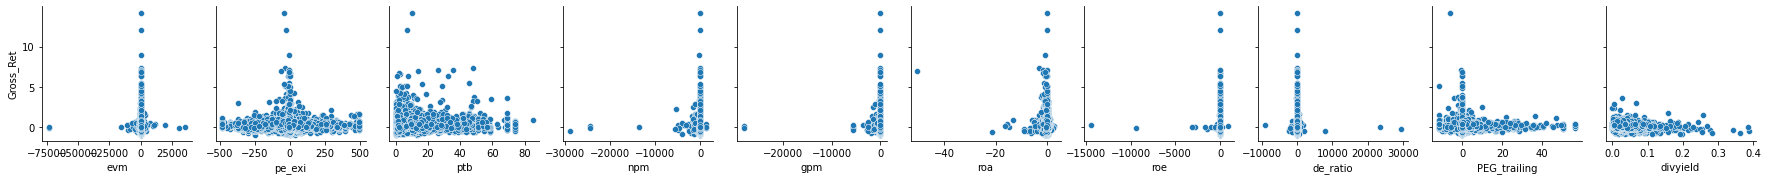

In [32]:
sns.pairplot(data=data_with_metrics,
             y_vars=['Gross_Ret'],
            x_vars=['evm','pe_exi','ptb','npm','gpm','roa','roe','de_ratio','PEG_trailing','divyield'])


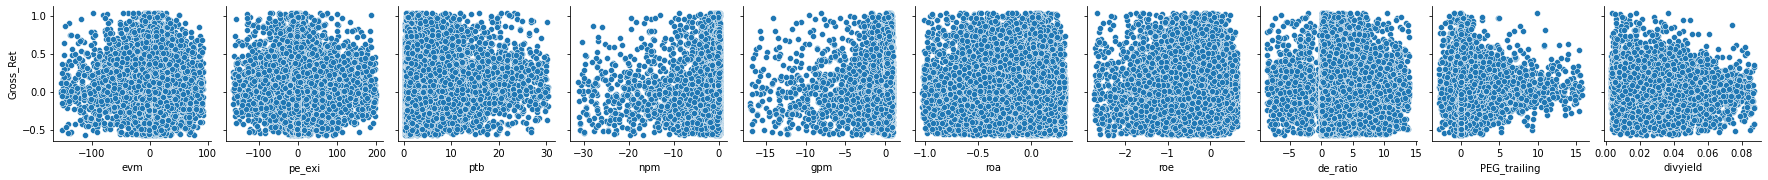

In [33]:
sns.pairplot(data=dat_filter,
             y_vars=['Gross_Ret'],
            x_vars=['evm','pe_exi','ptb','npm','gpm','roa','roe','de_ratio','PEG_trailing','divyield'])

#evm: enterprise value multiple
#pe_exi: price/earnings excluding extraordianry income 
#npm: net profit margin
#gpm: gross profit margin
#roa: retrun on assets
#roe: return on equity
#de_ratio: debt/equity
#ptb: price/book
#PEG_trailing: PEG 12ttm 
#divyield: dividend yield 

In [34]:
dat_filter.describe()

,Unnamed: 0,gvkey,fyearq,fqtr,fyr,ajexq,ajpq,currtrq,curuscnq,scfq,...,pe_exi,npm,gpm,roa,roe,efftax,de_ratio,ptb,PEG_trailing,divyield
count,32759.000000,32759.000000,32759.000000,32759.000000,32759.000000,32759.000000,32759.000000,32500.000000,145.000000,32677.0,...,30923.000000,29290.000000,29148.000000,31066.000000,29335.000000,20527.000000,31260.000000,29869.000000,16220.000000,12490.000000
mean,194695.912696,62850.822644,2018.956439,2.394975,11.249336,1.008842,1.008816,1.000009,0.758466,7.0,...,10.504517,-0.542248,0.198367,-0.003847,-0.095028,0.072930,2.383185,3.566001,1.008656,0.025277
std,132095.741676,65510.725160,0.810157,1.074012,2.089015,0.155571,0.157369,0.001648,0.015590,0.0,...,36.002761,2.770451,1.454985,0.228202,0.455755,10.425959,3.165956,4.245244,1.939258,0.015929
min,80.000000,1045.000000,2017.000000,1.000000,3.000000,0.016667,0.016667,1.000000,0.705500,7.0,...,-166.045822,-31.375507,-17.015699,-1.026102,-2.716972,-844.555556,-8.645066,0.344017,-2.843763,0.003198
25%,83760.500000,17074.000000,2018.000000,1.000000,12.000000,1.000000,1.000000,1.000000,0.748200,7.0,...,-3.868349,-0.067191,0.218861,-0.000999,-0.125193,0.131453,0.461971,1.153980,0.004496,0.013228
50%,187423.000000,29722.000000,2019.000000,2.000000,12.000000,1.000000,1.000000,1.000000,0.760300,7.0,...,10.786364,0.041983,0.398757,0.057474,0.059047,0.214475,1.278518,1.964615,0.444102,0.022120
75%,286906.500000,119574.000000,2020.000000,3.000000,12.000000,1.000000,1.000000,1.000000,0.773600,7.0,...,22.119150,0.125928,0.658926,0.122800,0.125497,0.285058,3.240203,4.117073,1.245692,0.033288
max,501100.000000,332115.000000,2021.000000,4.000000,12.000000,5.000000,5.000000,1.297040,0.775700,7.0,...,198.000000,0.380264,0.927492,0.318744,0.632658,93.000000,13.989917,30.310976,15.712249,0.087131


In [35]:
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter).fit().summary()

#sm_ols('Gross_Ret ~ pe_exi ',data=dat_filter).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     15.14
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           3.91e-27
Time:                        11:26:59   Log-Likelihood:                 1710.1
No. Observations:                7272   AIC:                            -3398.
Df Residuals:                    7261   BIC:                            -3322.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0603      0.011      5.480      0.000       0.039       0.082
evm             -0.0020      0.000     -5.452      0.000      -0.003      -0.001
pe_exi           0.0006      0.000      3.284      0.001       0.000       0.001
npm              0.0030      0.033      0.091      0.928      -0.061       0.067
gpm             -0.0350      0.014     -2.457      0.014      -0.063      -0.007
roa             -0.0798      0.065     -1.227      0.220      -0.207       0.048
roe             -0.1544      0.038     -4.015      0.000      -0.230      -0.079
de_ratio         0.0009      0.001      0.751      0.452      -0.002       0.003
ptb              0.0120      0.002      7.858      0.000       0.009       0.015
PEG_trailing     0.0008      0.001      0.682      0.495      -0.001       0.003
divyield        -0.4848      0.164     -2.953      0.003      -0.807      -0.163
==============================================================================
Omnibus:                      331.039   Durbin-Watson:                   0.932
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1006.417
Skew:                           0.162   Prob(JB):                    2.88e-219
Kurtosis:                       4.794   Cond. No.                     1.96e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.96e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [36]:
dat_filter_2018 = dat_filter[dat_filter['fyearq'] == 2018.0]
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_2018).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     11.13
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           8.30e-19
Time:                        11:26:59   Log-Likelihood:                 1221.2
No. Observations:                2489   AIC:                            -2420.
Df Residuals:                    2478   BIC:                            -2356.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0520      0.015      3.533      0.000       0.023       0.081
evm             -0.0028      0.001     -5.455      0.000      -0.004      -0.002
pe_exi           0.0010      0.000      4.139      0.000       0.001       0.001
npm              0.1603      0.050      3.201      0.001       0.062       0.259
gpm             -0.0569      0.020     -2.870      0.004      -0.096      -0.018
roa             -0.0936      0.085     -1.103      0.270      -0.260       0.073
roe             -0.2310      0.053     -4.361      0.000      -0.335      -0.127
de_ratio        -0.0024      0.002     -1.450      0.147      -0.006       0.001
ptb              0.0139      0.002      6.945      0.000       0.010       0.018
PEG_trailing    -0.0023      0.001     -1.694      0.090      -0.005       0.000
divyield        -0.1668      0.238     -0.702      0.483      -0.633       0.299
==============================================================================
Omnibus:                       19.534   Durbin-Watson:                   1.143
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.432
Skew:                           0.010   Prob(JB):                     4.06e-07
Kurtosis:                       3.532   Cond. No.                     2.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
sm_ols('Gross_Ret ~ roe',data=dat_filter_2018).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.5756
Date:                Tue, 20 Apr 2021   Prob (F-statistic):              0.448
Time:                        11:26:59   Log-Likelihood:                 541.36
No. Observations:                9725   AIC:                            -1079.
Df Residuals:                    9723   BIC:                            -1064.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0135      0.002      5.787      0.000       0.009       0.018
roe            0.0043      0.006      0.759      0.448      -0.007       0.015
==============================================================================
Omnibus:                      782.068   Durbin-Watson:                   1.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1445.940
Skew:                           0.569   Prob(JB):                         0.00
Kurtosis:                       4.508   Cond. No.                         2.42
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
dat_filter_2019 = dat_filter[dat_filter['fyearq'] == 2019.0]
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_2019).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.035
Method:                 Least Squares   F-statistic:                     11.30
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           3.33e-19
Time:                        11:27:00   Log-Likelihood:                 792.73
No. Observations:                2859   AIC:                            -1563.
Df Residuals:                    2848   BIC:                            -1498.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0081      0.018     -0.451      0.652      -0.043       0.027
evm             -0.0022      0.001     -3.765      0.000      -0.003      -0.001
pe_exi           0.0006      0.000      2.092      0.037    3.95e-05       0.001
npm              0.1001      0.058      1.718      0.086      -0.014       0.214
gpm             -0.0317      0.023     -1.374      0.169      -0.077       0.014
roa              0.1295      0.105      1.229      0.219      -0.077       0.336
roe             -0.1635      0.067     -2.453      0.014      -0.294      -0.033
de_ratio         0.0012      0.002      0.593      0.553      -0.003       0.005
ptb              0.0119      0.003      4.534      0.000       0.007       0.017
PEG_trailing     0.0034      0.002      1.621      0.105      -0.001       0.008
divyield        -1.2482      0.259     -4.812      0.000      -1.757      -0.740
==============================================================================
Omnibus:                      184.357   Durbin-Watson:                   0.792
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.637
Skew:                          -0.586   Prob(JB):                     3.38e-53
Kurtosis:                       3.810   Cond. No.                     1.98e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.98e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
sm_ols('Gross_Ret ~ npm',data=dat_filter_2019).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     8.247
Date:                Tue, 20 Apr 2021   Prob (F-statistic):            0.00409
Time:                        11:27:00   Log-Likelihood:                 221.46
No. Observations:               10246   AIC:                            -438.9
Df Residuals:                   10244   BIC:                            -424.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0291      0.002    -12.225      0.000      -0.034      -0.024
npm            0.0024      0.001      2.872      0.004       0.001       0.004
==============================================================================
Omnibus:                      529.457   Durbin-Watson:                   1.423
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1015.580
Skew:                           0.384   Prob(JB):                    2.95e-221
Kurtosis:                       4.338   Cond. No.                         2.93
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
dat_filter_2020 = dat_filter[dat_filter['fyearq'] == 2020.0]
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_2020).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     5.755
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           1.45e-08
Time:                        11:27:00   Log-Likelihood:                 277.14
No. Observations:                1892   AIC:                            -532.3
Df Residuals:                    1881   BIC:                            -471.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1875      0.023      8.277      0.000       0.143       0.232
evm             -0.0007      0.001     -1.076      0.282      -0.002       0.001
pe_exi        9.725e-06      0.000      0.026      0.979      -0.001       0.001
npm             -0.1046      0.056     -1.883      0.060      -0.214       0.004
gpm             -0.0378      0.029     -1.299      0.194      -0.095       0.019
roa             -0.0805      0.141     -0.572      0.568      -0.357       0.196
roe              0.0356      0.073      0.488      0.626      -0.107       0.179
de_ratio         0.0063      0.003      2.454      0.014       0.001       0.011
ptb              0.0023      0.003      0.760      0.448      -0.004       0.008
PEG_trailing     0.0007      0.002      0.277      0.782      -0.004       0.006
divyield        -1.8890      0.331     -5.713      0.000      -2.538      -1.241
==============================================================================
Omnibus:                      123.954   Durbin-Watson:                   1.281
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              201.917
Skew:                           0.507   Prob(JB):                     1.43e-44
Kurtosis:                       4.238   Cond. No.                     1.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
dat_filter_q1 = dat_filter[dat_filter.datadate.str.endswith('03-31')] #filter by rows ending in 3-31
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_q1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     3.178
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           0.000470
Time:                        11:27:00   Log-Likelihood:                 981.98
No. Observations:                1950   AIC:                            -1942.
Df Residuals:                    1939   BIC:                            -1881.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1167      0.017      6.770      0.000       0.083       0.151
evm             -0.0006      0.001     -1.061      0.289      -0.002       0.001
pe_exi       -5.597e-05      0.000     -0.176      0.860      -0.001       0.001
npm             -0.0850      0.049     -1.735      0.083      -0.181       0.011
gpm             -0.0191      0.021     -0.903      0.366      -0.061       0.022
roa             -0.0604      0.098     -0.619      0.536      -0.252       0.131
roe             -0.0943      0.061     -1.550      0.121      -0.214       0.025
de_ratio         0.0004      0.002      0.201      0.841      -0.003       0.004
ptb              0.0076      0.002      3.199      0.001       0.003       0.012
PEG_trailing    -0.0027      0.002     -1.611      0.107      -0.006       0.001
divyield        -0.2578      0.237     -1.089      0.276      -0.722       0.206
==============================================================================
Omnibus:                      562.804   Durbin-Watson:                   1.742
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2709.631
Skew:                           1.289   Prob(JB):                         0.00
Kurtosis:                       8.167   Cond. No.                     1.87e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
dat_filter_q2 = dat_filter[dat_filter.datadate.str.endswith('06-30')] #filter by rows ending in 6-30
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_q2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     20.06
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           1.02e-35
Time:                        11:27:00   Log-Likelihood:                 1481.2
No. Observations:                1960   AIC:                            -2940.
Df Residuals:                    1949   BIC:                            -2879.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0523      0.012      4.402      0.000       0.029       0.076
evm              0.0004      0.000      1.201      0.230      -0.000       0.001
pe_exi           0.0006      0.000      3.420      0.001       0.000       0.001
npm             -0.0465      0.034     -1.388      0.165      -0.112       0.019
gpm             -0.0406      0.016     -2.597      0.009      -0.071      -0.010
roa             -0.1609      0.074     -2.187      0.029      -0.305      -0.017
roe              0.0767      0.042      1.809      0.071      -0.006       0.160
de_ratio        -0.0037      0.001     -2.608      0.009      -0.006      -0.001
ptb              0.0052      0.002      3.307      0.001       0.002       0.008
PEG_trailing     0.0006      0.001      0.426      0.670      -0.002       0.003
divyield        -0.8017      0.183     -4.382      0.000      -1.161      -0.443
==============================================================================
Omnibus:                      249.733   Durbin-Watson:                   1.941
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              984.506
Skew:                           0.573   Prob(JB):                    1.65e-214
Kurtosis:                       6.277   Cond. No.                     1.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
dat_filter_q3 = dat_filter[dat_filter.datadate.str.endswith('09-30')] #filter by rows ending in 3-31
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_q3).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.070
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     14.44
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           5.25e-25
Time:                        11:27:01   Log-Likelihood:                 304.89
No. Observations:                1943   AIC:                            -587.8
Df Residuals:                    1932   BIC:                            -526.5
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.1362      0.024      5.789      0.000       0.090       0.182
evm             -0.0050      0.001     -5.819      0.000      -0.007      -0.003
pe_exi          -0.0002      0.000     -0.381      0.703      -0.001       0.001
npm              0.1983      0.072      2.745      0.006       0.057       0.340
gpm             -0.0533      0.032     -1.689      0.091      -0.115       0.009
roa             -0.2569      0.137     -1.877      0.061      -0.525       0.012
roe             -0.5912      0.085     -6.945      0.000      -0.758      -0.424
de_ratio         0.0060      0.003      2.225      0.026       0.001       0.011
ptb              0.0258      0.004      7.312      0.000       0.019       0.033
PEG_trailing    -0.0036      0.002     -1.499      0.134      -0.008       0.001
divyield         0.3725      0.355      1.048      0.295      -0.324       1.069
==============================================================================
Omnibus:                      107.349   Durbin-Watson:                   0.878
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              138.711
Skew:                           0.524   Prob(JB):                     7.57e-31
Kurtosis:                       3.784   Cond. No.                     2.04e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.04e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
dat_filter_q4 = dat_filter[dat_filter.datadate.str.endswith('12-31')] #filter by rows ending in 3-31
sm_ols('Gross_Ret ~ evm + pe_exi + npm + gpm + roa + roe + de_ratio + ptb + PEG_trailing + divyield',data=dat_filter_q4).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Gross_Ret   R-squared:                       0.102
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     15.93
Date:                Tue, 20 Apr 2021   Prob (F-statistic):           1.94e-27
Time:                        11:27:01   Log-Likelihood:                 44.709
No. Observations:                1419   AIC:                            -67.42
Df Residuals:                    1408   BIC:                            -9.583
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0835      0.032     -2.593      0.010      -0.147      -0.020
evm             -0.0056      0.001     -5.752      0.000      -0.008      -0.004
pe_exi           0.0028      0.001      4.602      0.000       0.002       0.004
npm              0.2031      0.104      1.948      0.052      -0.001       0.408
gpm             -0.0596      0.041     -1.446      0.149      -0.140       0.021
roa              0.2981      0.186      1.601      0.110      -0.067       0.663
roe             -0.1594      0.101     -1.576      0.115      -0.358       0.039
de_ratio         0.0010      0.003      0.287      0.774      -0.006       0.008
ptb              0.0188      0.004      4.253      0.000       0.010       0.027
PEG_trailing     0.0059      0.004      1.447      0.148      -0.002       0.014
divyield        -1.8461      0.483     -3.824      0.000      -2.793      -0.899
==============================================================================
Omnibus:                       29.696   Durbin-Watson:                   0.659
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.463
Skew:                           0.048   Prob(JB):                     0.000266
Kurtosis:                       2.481   Cond. No.                     1.99e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.99e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""